# Improving Bank Marketing with Machine Learning
### Group 7 - Gary Bair, Hunter Blum, Jacqueline Urenda

### Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Sklearn packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV


#pipeline tools
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

#resampling tools
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

#feature selection
from sklearn.decomposition import PCA

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, classification_report

import warnings
warnings.filterwarnings("ignore")

#pandas settings
pd.set_option('display.max_columns', None)

# DMBA packages
from dmba import gainsChart, liftChart

### Read in Data

In [2]:
bank = pd.read_csv("bank-additional-full.csv", delimiter=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## EDA

### Structure
Dimensions

In [3]:
print("The data has", bank.shape[1], "features.")
print("The data has", bank.shape[0], "observations.")

The data has 21 features.
The data has 41188 observations.


Data Types

In [4]:
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
bank.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

### NAs
By column - Looks like we don't have to worry about NAs

In [6]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
#descriptive stats:

bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


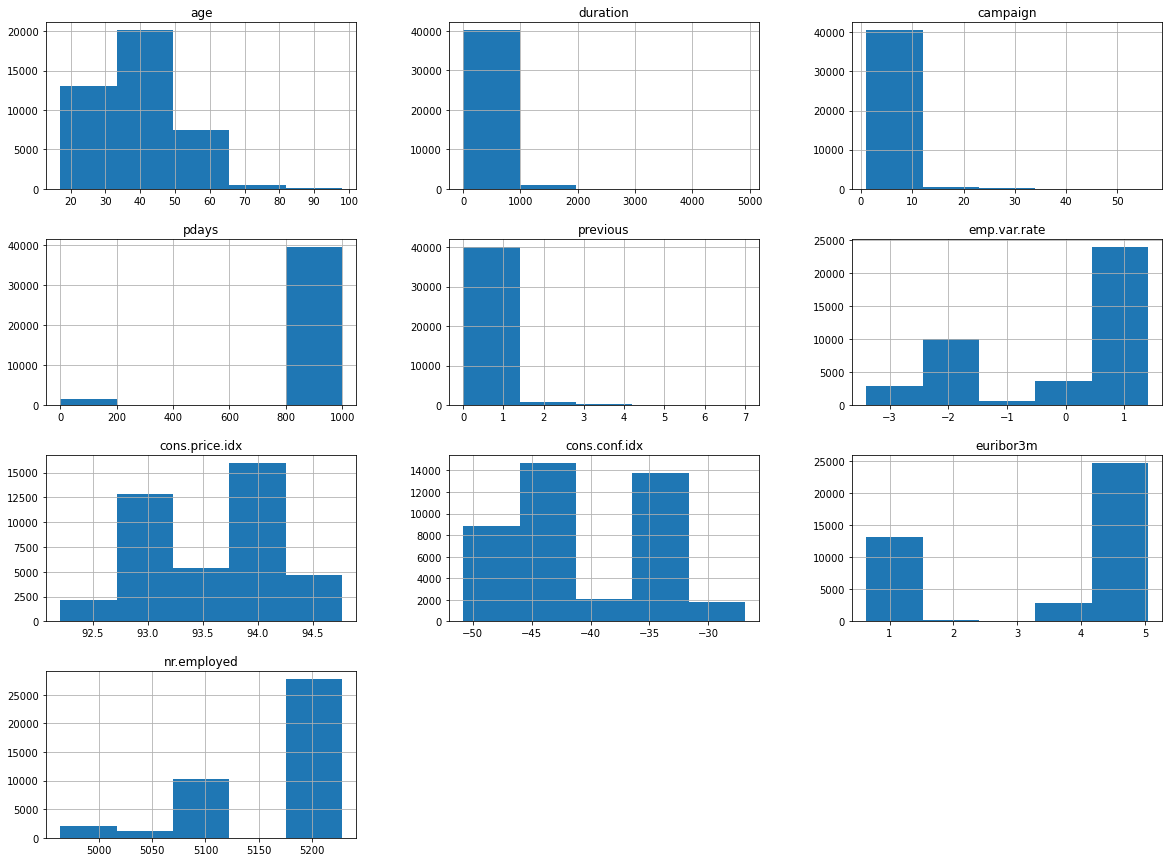

In [8]:
#distribution of numerical columns
bank.hist(figsize=(20,15),bins=5)
plt.show()

"Age" seems most normally distributed but still appears to be right skewed. "Duration", "Campaign", and "previous" variables seem very rightly skewed. "pdays", "emp.var.rate", and "nr.employed" are heavily left skewed. Several variables don't have a normal distribution.

In [9]:
#calculating the skewness of each numeric variable

bank.skew()

age               0.784697
duration          3.263141
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

"Duration", "campaign", "pdays" and "previous" have the most skewness

### Outlier Analysis

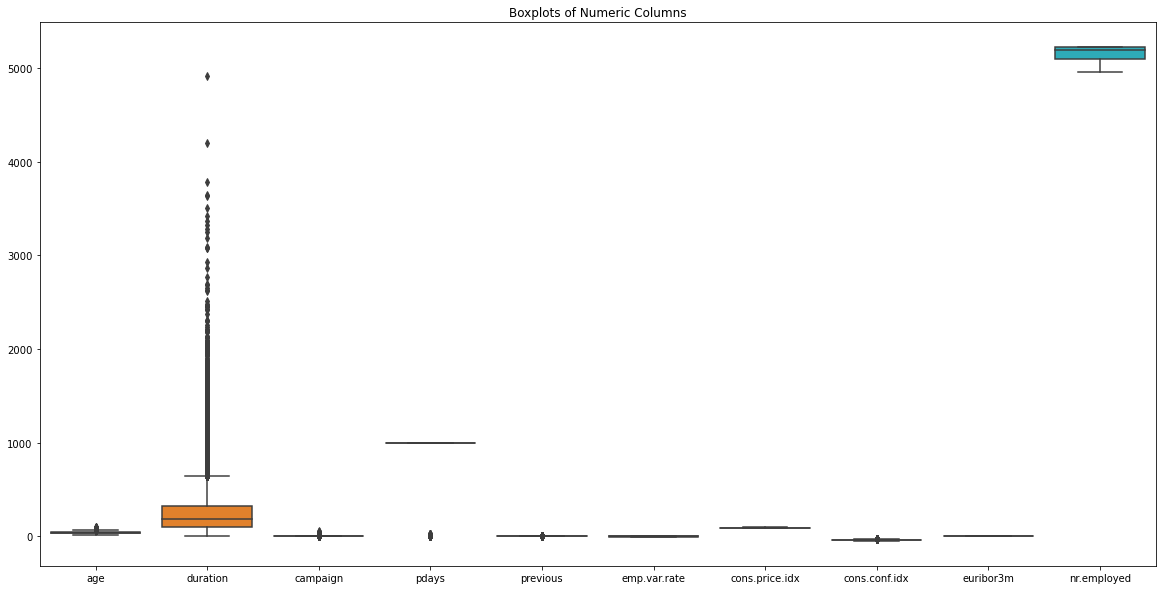

In [10]:
#outlier analysis


plt.figure(figsize=(20,10))
sns.boxplot(data = bank);
plt.title('Boxplots of Numeric Columns')
plt.show()

Boxplots show outliers in "duration", "campaign", "pdays", "previous" and "con.price.idx"

### Distribution of Label

Text(0.5, 1.0, 'Distribution of Term Deposits')

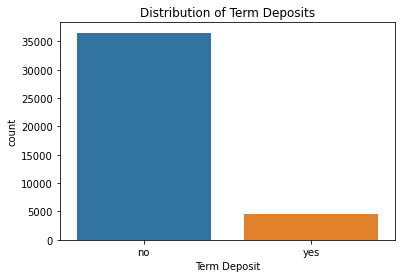

In [11]:
sns.countplot(bank['y'])
plt.xlabel("Term Deposit")
plt.title("Distribution of Term Deposits")

In [12]:
y_count = bank.groupby(['y'])['y'].count()
yes_per = round(y_count.yes/bank.shape[0]*100,2)
no_per = round(y_count.no/bank.shape[0]*100,2)

print(y_count.yes, "(" + str(yes_per) + "%)", "of observations responded yes to a term deposit")
print(y_count.no, "(" + str(no_per) + "%)", "of observations responded no to a term deposit")


4640 (11.27%) of observations responded yes to a term deposit
36548 (88.73%) of observations responded no to a term deposit


### Encode Categorical Variables
Target variable is now y_yes

In [13]:
bank_cat = bank.select_dtypes('object')
bank_num = bank.select_dtypes(['float64', 'int64'])
OH_encoder = OneHotEncoder(drop = 'if_binary', sparse=False)
bank_coded = OH_encoder.fit_transform(bank_cat)
bank_coded = pd.DataFrame(bank_coded, columns = OH_encoder.get_feature_names_out())
bank_coded = pd.concat([bank_coded, bank_num], axis = 1)
bank_coded.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


### Correlation Matrix

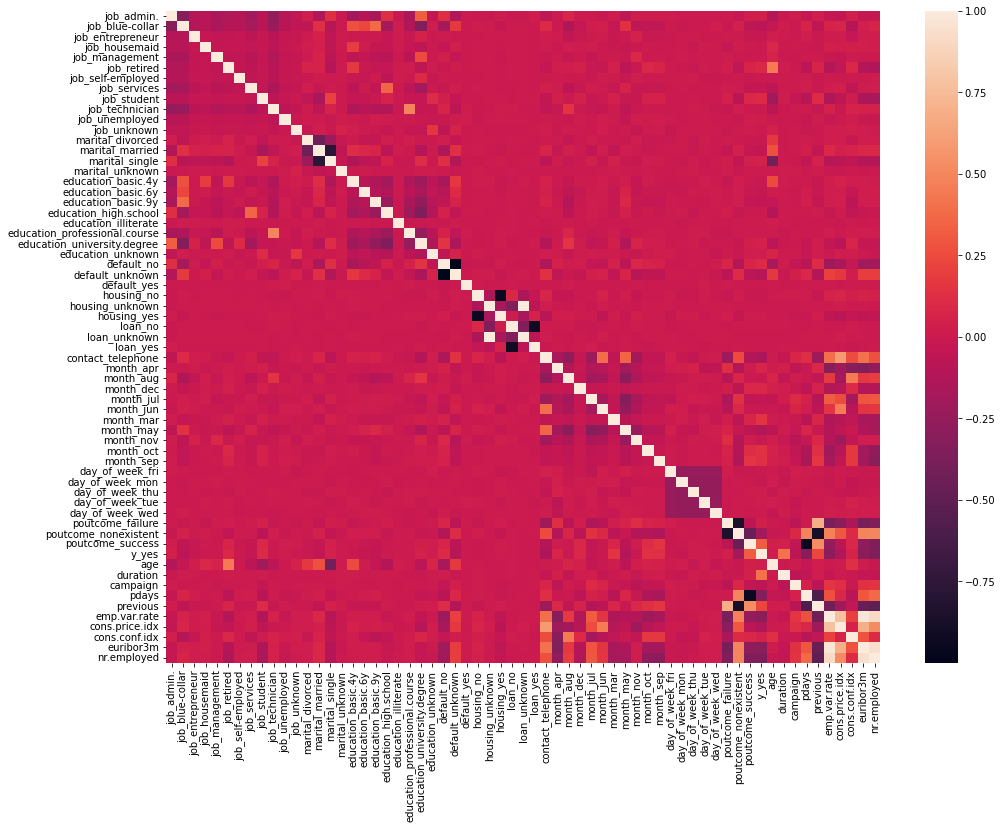

In [14]:
plt.figure(figsize = (16,12))
sns.heatmap(bank_coded.corr())
plt.show()

### Feature Selection
Zero Variance Variables

In [102]:
X = bank_coded.drop(columns = ['y_yes'])
y = bank_coded['y_yes']
low_var = VarianceThreshold(threshold=0.1)
low_var.fit(X)
dropcols = [column for column in X.columns
           if column not in
X.columns[low_var.get_support()]]
for features in dropcols:
    print(features)
    
X_highvar = X.drop(dropcols, axis = 1)

job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_unemployed
job_unknown
marital_divorced
marital_unknown
education_basic.4y
education_basic.6y
education_illiterate
education_unknown
default_yes
housing_unknown
loan_unknown
month_apr
month_dec
month_mar
month_nov
month_oct
month_sep
poutcome_failure
poutcome_success


Multicollinearity

In [103]:
X_vif = pd.DataFrame()
X_vif['variable'] = X_highvar.columns
X_vif['vif'] = [variance_inflation_factor(X_highvar.values, i)
               for i in range(len(X_highvar.columns))]
# housing_no and loan_no were perfectly correlated with their counterparts so we'll remove them
X_clean = X_highvar.drop(columns = ['housing_no', 'loan_no'])
X_vif = pd.DataFrame()
X_vif['variable'] = X_clean.columns
X_vif['vif'] = [variance_inflation_factor(X_clean.values, i)
               for i in range(len(X_clean.columns))]
drop = list(X_vif[X_vif['vif']>10].variable)
X_clean = X_clean.drop(columns = drop, axis = 1)

## Modelling
### Split Data
Note: Planning on using CV for tuning, so just doing a train and test split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

# Undersampled Data
undersampler = RandomUnderSampler(random_state = 123)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

### k-NN

In [105]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

neighbors = list(range(1,27,2))
weight = ['uniform', 'distance']

params = dict(knn__n_neighbors = neighbors,
             knn__weights = weight)

knn_pipe = Pipeline(steps = [('scaler', scaler), ('knn', knn)])

Unbalanced

In [106]:
knn_tuned = GridSearchCV(knn_pipe, params, n_jobs = -1)
knn_tuned.fit(X_train, y_train)
knn_reg_pred = knn_tuned.predict(X_test)
print(knn_tuned.best_params_)
print(classification_report(y_test, knn_reg_pred))

{'knn__n_neighbors': 25, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      7298
         1.0       0.68      0.28      0.40       940

    accuracy                           0.90      8238
   macro avg       0.80      0.63      0.67      8238
weighted avg       0.89      0.90      0.88      8238



In [107]:
knn_reg_acc = accuracy_score(y_test, knn_reg_pred)
knn_reg_f1 = f1_score(y_test, knn_reg_pred)

Balanced - A lot better recall, but precision took a big hit.

In [108]:
knn_baltuned = GridSearchCV(knn_pipe, params, n_jobs = -1)
knn_baltuned.fit(X_under, y_under)
knn_bal_pred = knn_baltuned.predict(X_test)
print(knn_baltuned.best_params_)
print(classification_report(y_test, knn_bal_pred))

{'knn__n_neighbors': 25, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      7298
         1.0       0.41      0.71      0.52       940

    accuracy                           0.85      8238
   macro avg       0.68      0.79      0.71      8238
weighted avg       0.90      0.85      0.86      8238



In [109]:
knn_bal_acc = accuracy_score(y_test, knn_bal_pred)
knn_bal_f1 = f1_score(y_test, knn_bal_pred)

### Neural Networks

In [110]:
neural_net = MLPClassifier(solver = 'sgd')
hidden_layer = [(10,30,10), (20,)]
activation = ['relu', 'logistic', 'tanh']
alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate = ['constant', 'adaptive']

neural_pipe = Pipeline(steps=[('scaler', scaler),('neural_net', neural_net)])

params = dict(neural_net__hidden_layer_sizes = hidden_layer, neural_net__activation = activation, neural_net__alpha = alpha,
             neural_net__learning_rate = learning_rate)

In [111]:
neural_tuned = GridSearchCV(neural_pipe, params, n_jobs = 6)
neural_tuned.fit(X_train, y_train)
neural_tuned_pred = neural_tuned.predict(X_test)
print(neural_tuned.best_params_)
print(classification_report(y_test, neural_tuned_pred))

{'neural_net__activation': 'tanh', 'neural_net__alpha': 0.0001, 'neural_net__hidden_layer_sizes': (10, 30, 10), 'neural_net__learning_rate': 'constant'}
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7298
         1.0       0.64      0.47      0.54       940

    accuracy                           0.91      8238
   macro avg       0.79      0.72      0.75      8238
weighted avg       0.90      0.91      0.90      8238



In [112]:
nnet_reg_acc = accuracy_score(y_test, neural_tuned_pred)
nnet_reg_f1 = f1_score(y_test, neural_tuned_pred)

In [113]:
neural_baltuned = GridSearchCV(neural_pipe, params, n_jobs = -1)
neural_baltuned.fit(X_under, y_under)
neural_bal_pred = neural_baltuned.predict(X_test)
print(neural_baltuned.best_params_)
print(classification_report(y_test, neural_bal_pred))

{'neural_net__activation': 'relu', 'neural_net__alpha': 0.01, 'neural_net__hidden_layer_sizes': (10, 30, 10), 'neural_net__learning_rate': 'adaptive'}
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      7298
         1.0       0.38      0.89      0.53       940

    accuracy                           0.82      8238
   macro avg       0.68      0.85      0.71      8238
weighted avg       0.91      0.82      0.85      8238



In [114]:
nnet_bal_acc = accuracy_score(y_test, neural_bal_pred)
nnet_bal_f1 = f1_score(y_test, neural_bal_pred)

### XGBoost

In [66]:
X = bank.drop(columns = ['y'])
y = bank[['y']]

oe = OrdinalEncoder()
y = oe.fit_transform(y)

In [67]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [68]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

# Undersampled Data
undersampler = RandomUnderSampler(random_state = 123)
X_train2, y_train2 = undersampler.fit_resample(X_train2, y_train2)

In [69]:
cat_variables = ['job', 
                 'marital', 
                 'education', 
                 'default', 
                 'housing', 
                 'loan', 
                 'contact', 
                 'month', 
                 'day_of_week', 
                 'poutcome']
num_variables = ['age', 
                 'duration',
                 'campaign',
                 'pdays',
                 'previous',
                 'emp.var.rate', 
                 'cons.conf.idx', 
                 'euribor3m', 
                 'nr.employed']

In [70]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], remainder = 'passthrough')),
                          ('k_best', SelectKBest(k = 20)),
                          ('xgBoost', xgb.XGBClassifier(objective="binary:logistic",
                                                        tree_method = 'gpu_hist'))])

Unbalanced xgboost

In [71]:
search_space = [{'xgBoost__n_estimators': [50, 100, 150, 200, 250, 300],
                 'xgBoost__learning_rate': [0.01, 0.1, 0.3, .05, 1],
                 'xgBoost__max_depth': range(3,21,2),
                 'xgBoost__colsample_bytree': [i/10.0 for i in range(3,10)],
                 'xgBoost__gamma': [i/10.0 for i in range(5)],
                 'xgBoost__reg_alpha' : [1e-5, 1e-2, 0.1, .3],
                 'xgBoost__reg_lambda' : [1e-5, 1e-2, 0.1,.3]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

search = RandomizedSearchCV(full_pipeline, 
                            param_distributions = search_space, 
                            n_iter = 200, 
                            cv = kfold,
                            scoring ='recall',
                            n_jobs = 4)
result = search.fit(X_train2, y_train2)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=nan):
{'xgBoost__reg_lambda': 0.1, 'xgBoost__reg_alpha': 0.01, 'xgBoost__n_estimators': 300, 'xgBoost__max_depth': 11, 'xgBoost__learning_rate': 0.3, 'xgBoost__gamma': 0.4, 'xgBoost__colsample_bytree': 0.7}


In [72]:
xgb_pred = search.predict(X_test2)
print(classification_report(y_test2,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7298
         1.0       0.43      0.92      0.59       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.93      0.85      0.87      8238



In [73]:
recall_score(y_test2,xgb_pred)

0.924468085106383

In [74]:
xg_bal_acc = accuracy_score(y_test2, xgb_pred)
xg_bal_f1 = f1_score(y_test2, xgb_pred)

Balanced xgboost

### Extra Trees

In [75]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], remainder = 'passthrough')),
                          ('k_best', SelectKBest(k = 20)),
                          ('etc', ExtraTreesClassifier())])

In [76]:
search_space = [{'etc__n_estimators': [10, 50, 100, 500, 1000, 5000],
                 'etc__max_leaf_nodes': [5, 10, 15, 20, 25, 50], 
                 'etc__max_depth': range(2,21,1)}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

search_etc = RandomizedSearchCV(full_pipeline, 
                            param_distributions = search_space, 
                            n_iter = 200, 
                            cv = kfold,
                            scoring ='recall',
                            n_jobs = 4)
result = search_etc.fit(X_train2, y_train2)

print("Best parameter (CV score=%0.3f):" % search_etc.best_score_)
print(search_etc.best_params_)

Best parameter (CV score=nan):
{'etc__n_estimators': 500, 'etc__max_leaf_nodes': 10, 'etc__max_depth': 8}


In [77]:
etc_pred = search_etc.predict(X_test2)
print(classification_report(y_test,etc_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      7298
         1.0       0.38      0.71      0.49       940

    accuracy                           0.83      8238
   macro avg       0.67      0.78      0.70      8238
weighted avg       0.89      0.83      0.85      8238



In [78]:
recall_score(y_test2,etc_pred)

0.7074468085106383

In [79]:
etc_bal_acc = accuracy_score(y_test2, etc_pred)
etc_bal_f1 = f1_score(y_test2, etc_pred)

### Logistic Regression

In [80]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], remainder = 'passthrough')),
                          ('k_best', SelectKBest(k = 20)),
                          ('logreg', LogisticRegression(solver = 'saga'))])

In [81]:
search_space = [{'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                 'logreg__C': [0.01, 0.1, 0.3, .05, 1]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

search_log = RandomizedSearchCV(full_pipeline, 
                            param_distributions = search_space, 
                            n_iter = 200, 
                            cv = kfold,
                            scoring ='recall',
                            n_jobs = 4)
result = search_log.fit(X_train2, y_train2)

print("Best parameter (CV score=%0.3f):" % search_log.best_score_)
print(search_log.best_params_)

Best parameter (CV score=nan):
{'logreg__penalty': 'l1', 'logreg__C': 0.01}


In [82]:
lr_pred = search_log.predict(X_test2)
print(classification_report(y_test2,lr_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      7298
         1.0       0.43      0.89      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [83]:
recall_score(y_test2,lr_pred)

0.8851063829787233

In [84]:
log_bal_acc = accuracy_score(y_test2, lr_pred)
log_bal_f1 = f1_score(y_test2, lr_pred)

## Results
Create Results Dataframe

In [115]:
Models = ["knn reg", "knn under", "nnet reg", "nnet under", "xg under", "tree under", "logreg under"]
Accuracy = [knn_reg_acc, knn_bal_acc, nnet_reg_acc, nnet_bal_acc, xg_bal_acc, etc_bal_acc, log_bal_acc]
F1 = [knn_reg_f1, knn_bal_f1, nnet_reg_f1, nnet_bal_f1, xg_bal_f1, etc_bal_f1, log_bal_f1]
Dataset = ['Unbalanced', 'Undersampled', 'Unbalanced', 'Undersampled', 'Undersampled + KBest', 'Undersampled + KBest', 'Undersampled + KBest']

Results = pd.DataFrame(list(zip(Models, Accuracy, F1, Dataset)),
                      columns = ['Model', 'Accuracy', 'F1 Score', 'Data Used'])

Save results so we don't have to rerun models to updated charts

In [116]:
np.array(Results)

array([['knn reg', 0.9030104394270454, 0.3996994740796394, 'Unbalanced'],
       ['knn under', 0.8478999757222627, 0.5171483622350674,
        'Undersampled'],
       ['nnet reg', 0.9094440398154892, 0.5412054120541205, 'Unbalanced'],
       ['nnet under', 0.8216800194221898, 0.5326121539930003,
        'Undersampled'],
       ['xg under', 0.852391357125516, 0.5883547731888964,
        'Undersampled + KBest'],
       ['tree under', 0.8327263899004613, 0.4911373707533235,
        'Undersampled + KBest'],
       ['logreg under', 0.8534838553046856, 0.5795889933820968,
        'Undersampled + KBest']], dtype=object)

In [117]:
Results_matrix = np.array([['knn reg', 0.9030104394270454, 0.3996994740796394, 'Unbalanced'],
       ['knn under', 0.8478999757222627, 0.5171483622350674,
        'Undersampled'],
       ['nnet reg', 0.9094440398154892, 0.5412054120541205, 'Unbalanced'],
       ['nnet under', 0.8216800194221898, 0.5326121539930003,
        'Undersampled'],
       ['xg under', 0.852391357125516, 0.5883547731888964,
        'Undersampled + KBest'],
       ['tree under', 0.8327263899004613, 0.4911373707533235,
        'Undersampled + KBest'],
       ['logreg under', 0.8534838553046856, 0.5795889933820968,
        'Undersampled + KBest']], dtype=object)


Results_saved = pd.DataFrame(Results_matrix, columns=['Model', 'Accuracy', 'F1 Score', 'Data Used'])
Results_saved

,Model,Accuracy,F1 Score,Data Used
0,knn reg,0.90301,0.399699,Unbalanced
1,knn under,0.8479,0.517148,Undersampled
2,nnet reg,0.909444,0.541205,Unbalanced
3,nnet under,0.82168,0.532612,Undersampled
4,xg under,0.852391,0.588355,Undersampled + KBest
5,tree under,0.832726,0.491137,Undersampled + KBest
6,logreg under,0.853484,0.579589,Undersampled + KBest


Accuracy Plot

<Figure size 432x288 with 0 Axes>

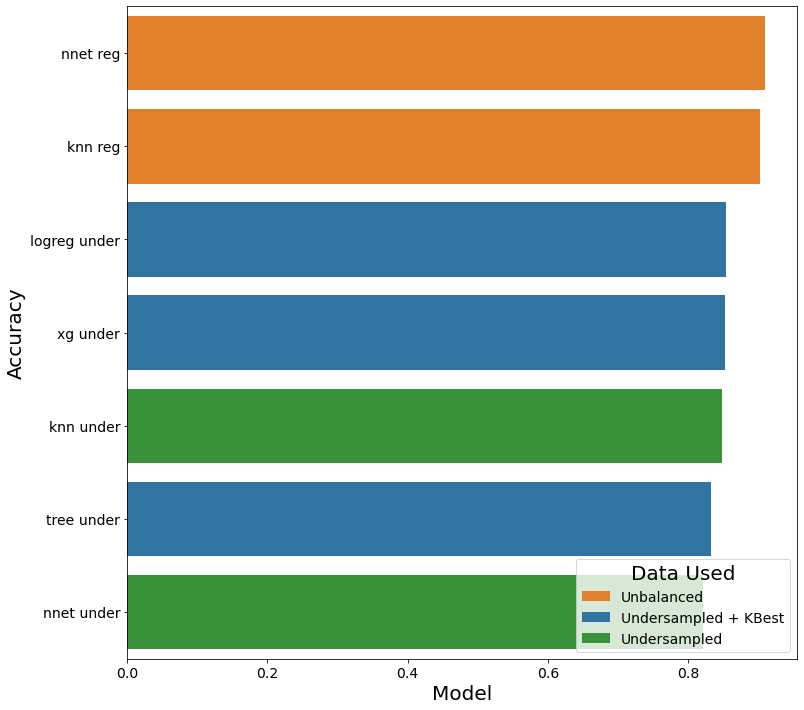

In [118]:
Results_acc = Results_saved.sort_values(by=['Accuracy'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotac = sns.barplot(y = 'Model', x = 'Accuracy', hue = 'Data Used', data = Results_acc, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('Accuracy',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
legend = plt.legend(loc = 'lower right', title = 'Data Used', fontsize = 14)
plt.setp(legend.get_title(), fontsize = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

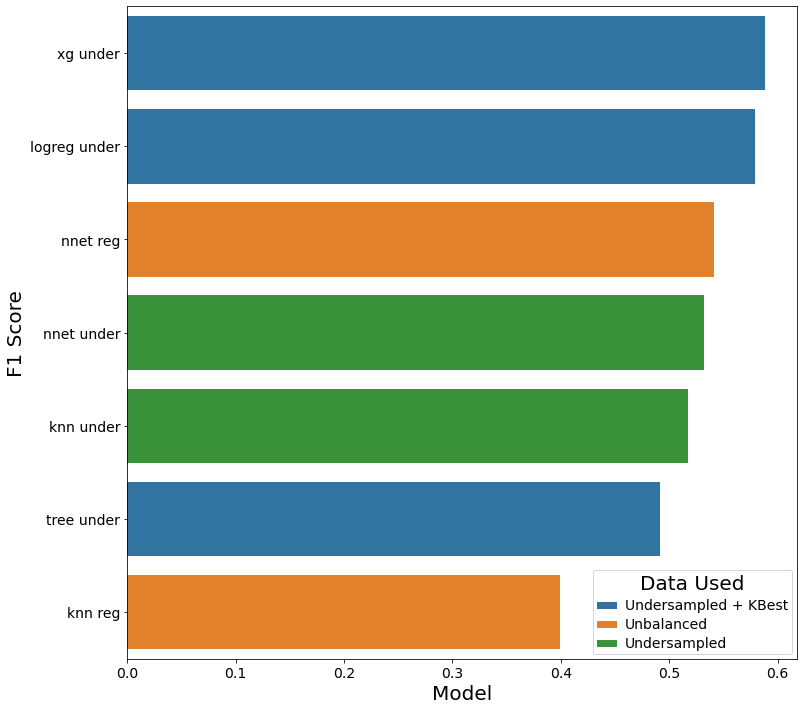

In [119]:
Results_f1 = Results_saved.sort_values(by=['F1 Score'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotf1 = sns.barplot(y = 'Model', x = 'F1 Score', hue = 'Data Used', data = Results_f1, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('F1 Score',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
plt.setp(plotf1.get_legend().get_texts(), fontsize = 14)
plt.setp(plotf1.get_legend().get_title(), fontsize = 20)
plt.show()

Gain and Lift Charts for Selected Models

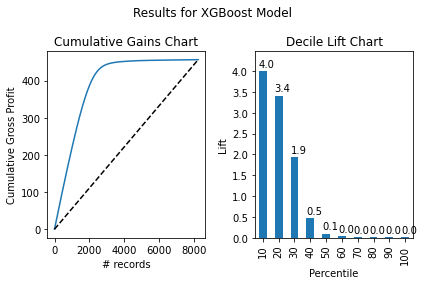

In [120]:
xg_probs = search.predict_proba(X_test2)
neg, pos = zip(*xg_probs)
xg_probs = pd.Series(pos)
xg_probs_adj = xg_probs * (11.52/50)
xg_probs_sort = xg_probs_adj.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(xg_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gross Profit')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(xg_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for XGBoost Model")
plt.tight_layout()
plt.show()

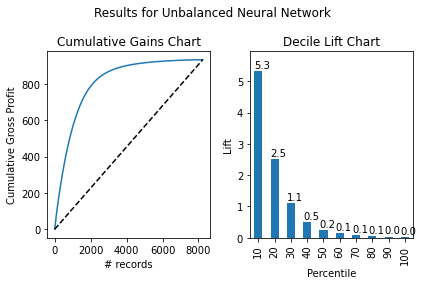

In [101]:
nnet_probs = neural_tuned.predict_proba(X_test)
neg, pos = zip(*nnet_probs)
nnet_probs = pd.Series(pos)
nnet_probs_sort = nnet_probs.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(nnet_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(nnet_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for Unbalanced Neural Network")
plt.tight_layout()
plt.show()